Taller 3 - métodos computacionales

1. Carros en un plano inclinado

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

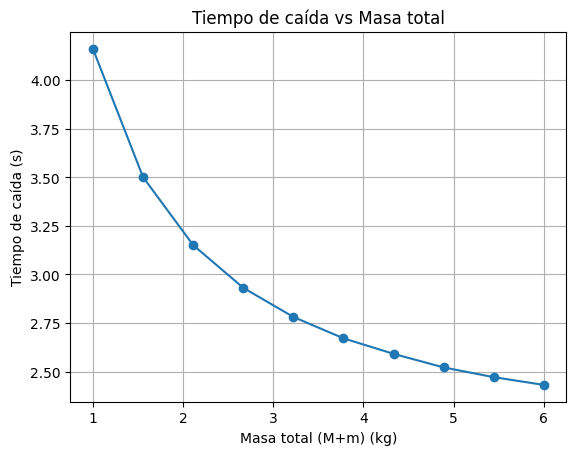

In [49]:
#MARCO DE REFERENCIA ALINEADO AL PLANO

g = 9.81  
theta = np.radians(30)  
gamma = 0.7 
m_carro = 1.0  
Ms = np.linspace(0, 5, 10)  
H = 10.0  #hipotenusa

#ecuación diferencial
def sistema(t, y, m_total):
    x, v = y  
    a = (m_total * g * np.sin(theta) - gamma * v**2) / m_total
    return [v, a]

#solución de la ecuación
tiempo_max = 5 
tiempos = []

for M in Ms:
    sol = solve_ivp(sistema, t_span=[0, 10], y0=[0, 0], args=(m_carro + M,), max_step=0.01)
    for i in range(len(sol.t)):
        if sol.y[0][i] >= H:  #miro cuando la posición es mayor que H
            tiempo_caida = sol.t[i] #guardo ese tiempo (el de caida)
            break
    tiempos.append(tiempo_caida)

plt.plot(Ms+m_carro, tiempos, 'o-')
plt.xlabel('Masa total (M+m) (kg)')
plt.ylabel('Tiempo de caída (s)')
plt.title('Tiempo de caída vs Masa total')
plt.grid(True)
plt.show()

¿El tiempo de caída de los carros depende de la masa que llevan encima?
 Sí, pues a medida que aumenta la masa adicional M, el tiempo de caída disminuye. Esto se debe a que al incrementar la masa, la fuerza gravitacional sobre el carro aumenta, resultando en una mayor aceleración hacia abajo y por ende un menor tiempo de caída. Además, la fuerza gravitacional domina sobre la fricción líquida en los rodamientos (que es una constante independiente de la masa). Es por eso que cuando la masa se hace muy grande, la fricción líquida se vuelve insignificante en comparación con la fuerza gravitacional, y el tiempo de caída tiende a un valor mínimo constante, que es el límite asintótico que se observa en la gráfica. 

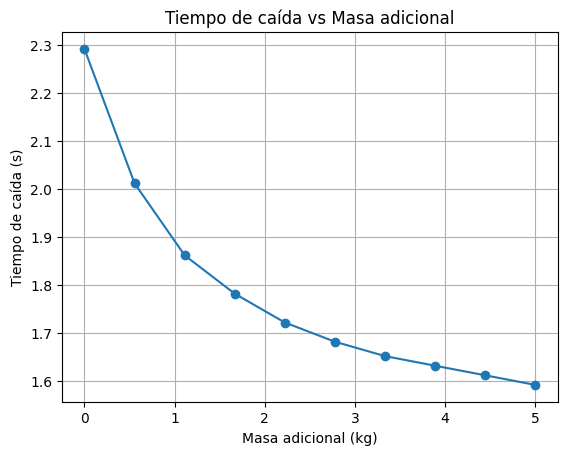

In [50]:
#MARCO DE REFERENCIA RECTO (borrar?)
g = 9.81  
theta = np.radians(30)  
gamma = 0.7 
m_carro = 1.0  
Ms = np.linspace(0, 5, 10)  
H = 10.0  #altura

#ecuación diferencial
def sistemaX(t, y, m_total):
    x, v = y  
    a = ((-gamma*v**2*np.cos(theta))/m_total) + ((m_total*g*np.cos(30)*np.sin(30))/m_total)
    return [v, a]

def sistemaY(t, y, m_total):
    x, v = y  
    a = -g + ((gamma*v**2*np.sin(theta))/m_total) + ((m_total*g*np.cos(30)*np.cos(30))/m_total)
    return [v, a]

#solución de la ecuación
tiempo_max = 5 

for M in Ms:
    solX = solve_ivp(sistemaX, t_span=[0, 10], y0=[0, 0], args=(m_carro + M,), max_step=0.01)
    
tiempos = []
for M in Ms:
    solY = solve_ivp(sistemaY, t_span=[0, 10], y0=[H, 0], args=(m_carro + M,), max_step=0.01)
    for i in range(len(sol.t)):
        if solY.y[0][i] <= 0:  #miro cuando la posición es mayor que H
            tiempo_caida = sol.t[i] #guardo ese tiempo (el de caida)
            break
    tiempos.append(tiempo_caida)

plt.plot(Ms, tiempos, 'o-')
plt.xlabel('Masa adicional (kg)')
plt.ylabel('Tiempo de caída (s)')
plt.title('Tiempo de caída vs Masa adicional')
plt.grid(True)
plt.show()

2. Comprobación observacional de la relatividad general

2.1 Simulación

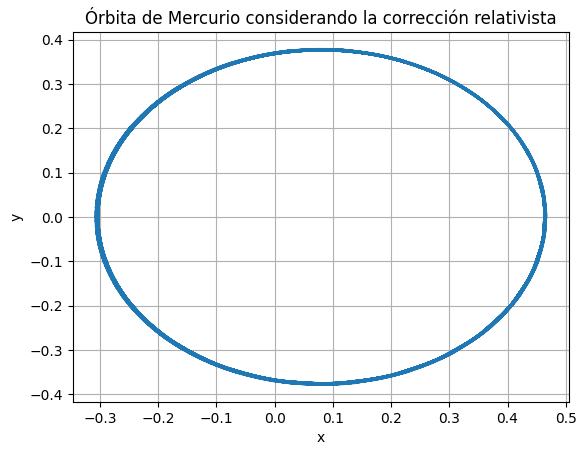

In [51]:
#constantes y condiciones iniciales
mu = 39.4234021 
alfa = 1.09778201e-8
a = 0.38709893 
e = 0.20563069

x0 = a * (1 + e)
y0 = 0
vx0 = 0
vy0 = np.sqrt(mu / a * (1 - e) / (1 + e))

#creo la ecuación diferencial del sistema
def sistema_fuerzas(t, y):
    x, y, vx, vy = y
    r = np.sqrt(x**2 + y**2)
    ax = -mu * (1 + alfa / r**2) * x / r**3
    ay = -mu * (1 + alfa / r**2) * y / r**3
    return [vx, vy, ax, ay]

t_span = (0., 10.)
y0 = [x0, y0, vx0, vy0]

#solucion de la ecuación diferencial
sol = solve_ivp(sistema_fuerzas, t_span, y0, max_step=0.01) #revisar
x = sol.y[0]
y = sol.y[1]

#gráfica
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Órbita de Mercurio considerando la corrección relativista')
plt.grid(True)
plt.show()

2.2 Precesión de la órbita

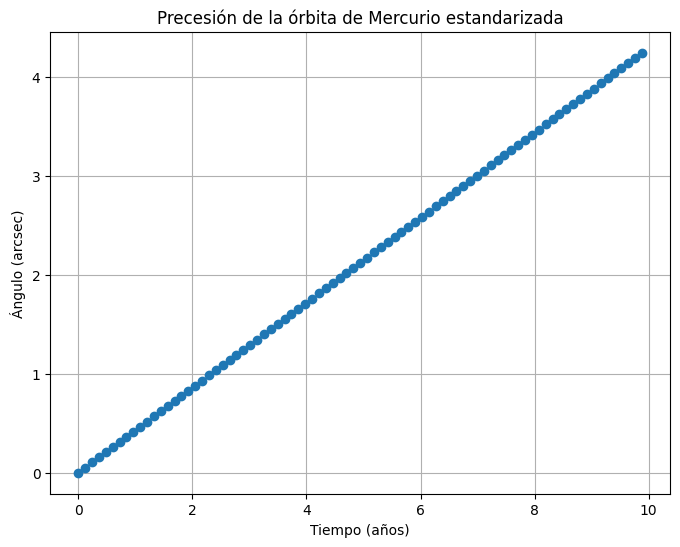

In [52]:
#establezco condición de producto punto
def evento(t,y):
    x, y, vx, vy = y
    return x*vx + y*vy

sol = solve_ivp(sistema_fuerzas, t_span, y0, max_step = 0.001, events=[evento])

#hallo el ángulo con arctan
angulos = []
for info in sol.y_events[0]:
    angulo = np.arctan2(info[1],info[0])
    angulos.append(angulo)

#estandarizo los ángulos al afelio
angulos_afelio = []
tiempos_afelio = []
i=0
for angulo in angulos:
    if np.abs(angulo) > 3 * np.pi / 2:
        angulos_afelio.append(np.abs(angulo) - 2 * np.pi)
        tiempos_afelio.append(sol.t_events[0][i])
    elif np.abs(angulo) > np.pi / 2:
        angulos_afelio.append(np.abs(angulo) - np.pi)
        tiempos_afelio.append(sol.t_events[0][i])
    else:
        angulos_afelio.append(np.abs(angulo))
        tiempos_afelio.append(sol.t_events[0][i])
    i += 1
    
angulos_grados = np.degrees(angulos_afelio)
angulos_arcsec = angulos_grados * 3600

#gráfica
plt.figure(figsize=(8, 6))
plt.plot(tiempos_afelio, np.abs(angulos_arcsec), 'o')
plt.xlabel('Tiempo (años)')
plt.ylabel('Ángulo (arcsec)')
plt.title('Precesión de la órbita de Mercurio estandarizada')
plt.grid(True)
plt.show()


In [57]:
from scipy.stats import linregress
pendiente = linregress(tiempos_afelio, np.abs(angulos_arcsec))
print(f"La pendiente es: {pendiente.slope}")


La pendiente es: 0.42986202523912764


3. 